In [4]:
%load_ext autoreload
%autoreload 2

from typing import List, Dict

import sys
import yaml
sys.path.append('.')
sys.path.append('..')

import time
from tqdm import tqdm
from pathlib import Path

import numpy as np
import jax
import jax.numpy as jnp
import matplotlib as mpl
import matplotlib.pyplot as plt
import datasets
from ml_collections.config_dict import ConfigDict
from analysis_utils import envs

%matplotlib inline
plt.style.use('/mnt/home/tnguyen/default.mplstyle')

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [14]:
# Read in the generated dataset
dataset_name = 'wdm/balmy-sun-69'
dataset_path = envs.DEFAULT_OUTPUT_DIR / (dataset_name + '.npz')

dataset = np.load(dataset_path)
gen_samples = dataset['samples']
cond = dataset['cond']
mask = dataset['mask']
truth_samples = dataset['truth']

# halo_mvir, m_wdm = cond[:, 0], cond[:, 1]
halo_mvir, m_wdm, sn1, sn2, agn1 = cond.T

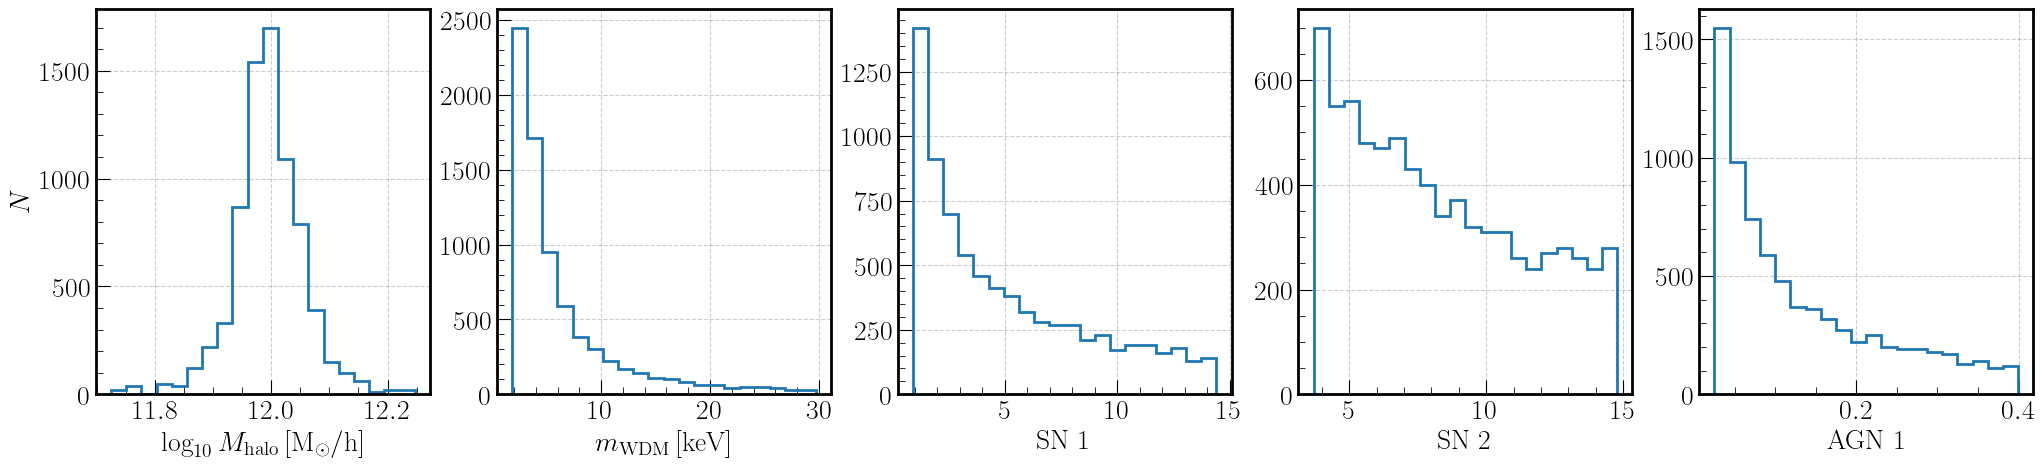

In [21]:
fig, axes = plt.subplots(1, 5, figsize=(25, 5))

axes[0].hist(halo_mvir, bins=20, histtype='step', lw=2)
axes[1].hist(m_wdm, bins=20, histtype='step', lw=2)
axes[2].hist(sn1, bins=20, histtype='step', lw=2)
axes[3].hist(sn2, bins=20, histtype='step', lw=2)
axes[4].hist(agn1, bins=20, histtype='step', lw=2)

axes[0].set_xlabel(r'$\log_{10} M_\mathrm{halo} \, [\rm M_\odot / h]$')
axes[1].set_xlabel(r'$m_\mathrm{WDM} \, [\rm keV]$')
axes[2].set_xlabel(r'SN 1')
axes[3].set_xlabel(r'SN 2')
axes[4].set_xlabel(r'AGN 1')
axes[0].set_ylabel(r'$N$')

plt.show()

In [22]:
# divide the data into bins by wdm mass
# wdm_mass_bins = [0, 5, 10, 20, 30]
# wdm_mass_bins = [1.85, 2.35, 3.40, 6.1, 30]
wdm_mass_bins = [2.35, 3.40, 6.1, 30]
num_wdm_bins = len(wdm_mass_bins) - 1

gen_samples_bins = []
truth_samples_bins = []
mask_bins = []

for i in range(len(wdm_mass_bins) - 1):
    m_min, m_max = wdm_mass_bins[i], wdm_mass_bins[i + 1]
    idx = np.where((m_wdm > m_min) & (m_wdm < m_max))[0]
    
    print(f'Bin {i} [{m_min}, {m_max}] keV: {len(idx)} samples')

    gen_samples_bins.append(gen_samples[idx])
    truth_samples_bins.append(truth_samples[idx])
    mask_bins.append(mask[idx])

Bin 0 [2.35, 3.4] keV: 1860 samples
Bin 1 [3.4, 6.1] keV: 2400 samples
Bin 2 [6.1, 30] keV: 2400 samples


### Subhalo mass function

In [23]:
def get_histogram_q(samples, bins, q, cumulative=False):
    """ Compute the qth percentile of a samples of histograms. """
    counts = [np.histogram(samples[i], bins=bins)[0] for i in range(samples.shape[0])]
    counts = np.stack(counts, axis=0)
    if cumulative:
        counts = counts.sum(1, keepdims=True) - np.cumsum(counts, axis=1)
    counts_q = np.nanpercentile(counts, q=q, axis=0)
    return counts_q

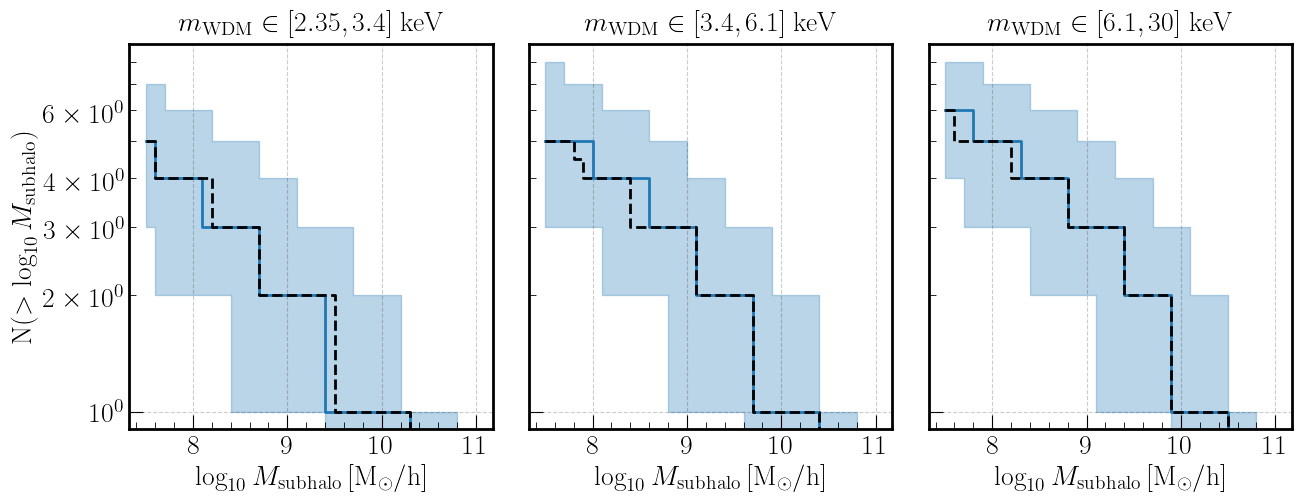

In [24]:
# define the bin for the subhalo mass function
# note that this is different from the bin for the wdm mass
bin_size = 0.1
plot_range = (7.5, 11)
q = [50, 16, 84]
cumulative = True
bins = np.arange(plot_range[0], plot_range[1] + bin_size, bin_size)
num_bins = len(bins) - 1
bins_plot = np.zeros(2 * num_bins)
bins_plot[::2] = bins[:-1] 
bins_plot[1::2] = bins[1:]

fig, axes = plt.subplots(
    1, num_wdm_bins, figsize=(5 * num_wdm_bins, 5), sharey=True, sharex=True)

for i in range(num_wdm_bins):
    ax = axes[i]

    # plot the generated samples
    counts_q = get_histogram_q(gen_samples_bins[i][..., -1], bins, q=q, cumulative=cumulative)
    ax.plot(
        bins_plot, counts_q[0].repeat(2), color='C0', lw=2, 
        label='score-based diff')
    ax.fill_between(
        bins_plot, counts_q[1].repeat(2), counts_q[2].repeat(2),
        color='C0', alpha=0.3)

    # plot the truth samples
    counts_q = get_histogram_q(truth_samples_bins[i][..., -1], bins, q=q, cumulative=cumulative)
    ax.plot(
        bins_plot, counts_q[0].repeat(2), color='k', lw=2, 
        ls='--', label='simulation')


axes[0].set_yscale('log')
axes[0].set_ylabel(r'N($> \log_{10} M_{\rm subhalo}$)')
for i, ax in enumerate(axes):
    ax.set_xlabel(r'$\log_{10} M_{\rm subhalo} \, [\rm M_\odot / h]$')

    title = r"$m_\mathrm{{WDM}} \in [{}, {}]$ keV".format(
        wdm_mass_bins[i], wdm_mass_bins[i + 1])
    ax.set_title(title, fontsize=20)

# create handles
handles, labels = ax.get_legend_handles_labels()
# fig.legend(
    # handles, labels, loc='upper center', ncol=2, fontsize=20)
fig.subplots_adjust(hspace=0.3, wspace=0.1)
plt.show()

In [26]:
# # define the bin for the subhalo mass function
# # note that this is different from the bin for the wdm mass
# bin_size = 0.1
# plot_range = (7.5, 11)
# q = [50, 16, 84]
# cumulative = True
# bins = np.arange(plot_range[0], plot_range[1] + bin_size, bin_size)
# num_bins = len(bins) - 1
# bins_plot = np.zeros(2 * num_bins)
# bins_plot[::2] = bins[:-1] 
# bins_plot[1::2] = bins[1:]

# colors = ['C0', 'C1', 'C2', 'C3']
# linestyles = ['-', '--', '-.', ':']

# fig, axes = plt.subplots(
#     1, 2, figsize=(10, 5), sharey=True, sharex=True)

# # plot the generated samples
# for i in range(num_wdm_bins):

#     label = r"$m_\mathrm{{WDM}} \in [{}, {}]$ keV".format(
#         wdm_mass_bins[i], wdm_mass_bins[i + 1])
#     counts_q = get_histogram_q(gen_samples_bins[i][..., -1], bins, q=q, cumulative=cumulative)
#     axes[0].plot(
#         bins_plot, counts_q[0].repeat(2), color=colors[i], lw=2,
#         ls=linestyles[i], label=label)

#     counts_q = get_histogram_q(truth_samples_bins[i][..., -1], bins, q=q, cumulative=cumulative)
#     axes[1].plot(
#         bins_plot, counts_q[0].repeat(2), color=colors[i], lw=2,
#         ls=linestyles[i], label=label)


# axes[0].set_yscale('log')
# axes[0].set_ylabel(r'N($> \log_{10} M_{\rm subhalo}$)')
# axes[0].set_xlabel(r'$\log_{10} M_{\rm subhalo} \, [\rm M_\odot / h]$')
# axes[1].set_xlabel(r'$\log_{10} M_{\rm subhalo} \, [\rm M_\odot / h]$')
# handles, labels = axes[0].get_legend_handles_labels()
# fig.legend(
#     handles, labels, fontsize=16, loc='upper center', ncol=2,
#     bbox_to_anchor=(0.5, 1.05))
# axes[0].text(
#     0.95, 0.95, 'score-based diff', transform=axes[0].transAxes,
#     fontsize=20, va='top', ha='right')
# axes[1].text(
#     0.95, 0.95, 'simulation', transform=axes[1].transAxes,
#     fontsize=20, va='top', ha='right')

# fig.subplots_adjust(hspace=0.3, wspace=0.1)
# plt.show()

### Radius

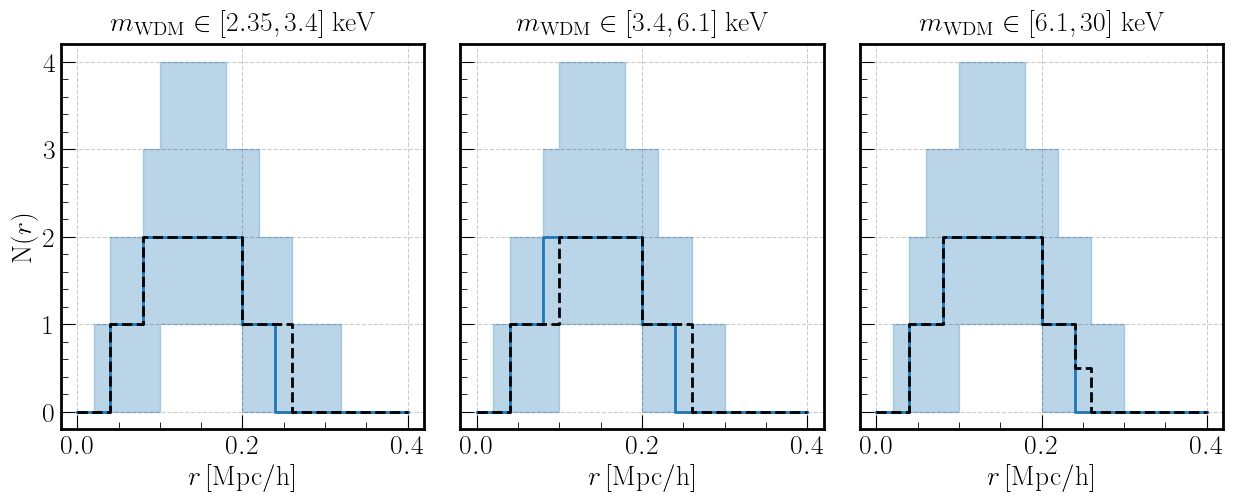

In [27]:
# define the bin for the subhalo mass function
# note that this is different from the bin for the wdm mass
bin_size = 0.02
plot_range = (0., 0.4)
q = [50, 16, 84]
cumulative = False
bins = np.arange(plot_range[0], plot_range[1] + bin_size, bin_size)
num_bins = len(bins) - 1
bins_plot = np.zeros(2 * num_bins)
bins_plot[::2] = bins[:-1] 
bins_plot[1::2] = bins[1:]

fig, axes = plt.subplots(
    1, num_wdm_bins, figsize=(5 * num_wdm_bins, 5), sharey=True, sharex=True)

for i in range(num_wdm_bins):
    ax = axes[i]

    # plot the generated samples
    pos = gen_samples_bins[i][..., :3]
    rad = np.linalg.norm(pos, axis=-1)
    counts_q = get_histogram_q(rad, bins, q=q, cumulative=cumulative)
    ax.plot(
        bins_plot, counts_q[0].repeat(2), color='C0', lw=2, 
        label='score-based diff')
    ax.fill_between(
        bins_plot, counts_q[1].repeat(2), counts_q[2].repeat(2),
        color='C0', alpha=0.3)

    # plot the truth samples
    pos = truth_samples_bins[i][..., :3]
    rad = np.linalg.norm(pos, axis=-1)
    counts_q = get_histogram_q(rad, bins, q=q, cumulative=cumulative)   
    ax.plot(
        bins_plot, counts_q[0].repeat(2), color='k', lw=2, 
        ls='--', label='simulation')

# axes[0].set_yscale('log')
axes[0].set_ylabel(r'N($r$)')
for i, ax in enumerate(axes):
    ax.set_xlabel(r'$r \, [\rm Mpc / h]$')

    title = r"$m_\mathrm{{WDM}} \in [{}, {}]$ keV".format(
        wdm_mass_bins[i], wdm_mass_bins[i + 1])
    ax.set_title(title, fontsize=20)

# create handles
handles, labels = ax.get_legend_handles_labels()
# fig.legend(
    # handles, labels, loc='upper center', ncol=2, fontsize=20)
fig.subplots_adjust(hspace=0.3, wspace=0.1)
plt.show()

### Density profiles

In [28]:
# calculate the density profiles for each WDM bins
r_min = 0.01
r_max = 0.5
num_bins = 5  # this is the number of bins for the density profile not the WDM mass
log_r_bins = np.linspace(np.log10(r_min), np.log10(r_max), num_bins + 1)

gen_log_rho = []
for i in range(num_wdm_bins):
    temp = []
    for samples in gen_samples_bins[i]:
        pos = samples[..., :3]
        rad = np.linalg.norm(pos, axis=-1)
        log_mvir = samples[..., -1]

        rho = jgnn_ut.particles.calc_rho(
            rad, 10**log_mvir, r_min, r_max, num_bins=num_bins)[0]
        temp.append(np.log10(rho))
    gen_log_rho.append(temp)

truth_log_rho = []
for i in range(num_wdm_bins):
    temp = []
    for samples in truth_samples_bins[i]:
        pos = samples[..., :3]
        rad = np.linalg.norm(pos, axis=-1)
        log_mvir = samples[..., -1]

        rho = jgnn_ut.particles.calc_rho(
            rad, 10**log_mvir, r_min, r_max, num_bins=num_bins)[0]
        temp.append(np.log10(rho))
    truth_log_rho.append(np.array(temp))

NameError: name 'jgnn_ut' is not defined

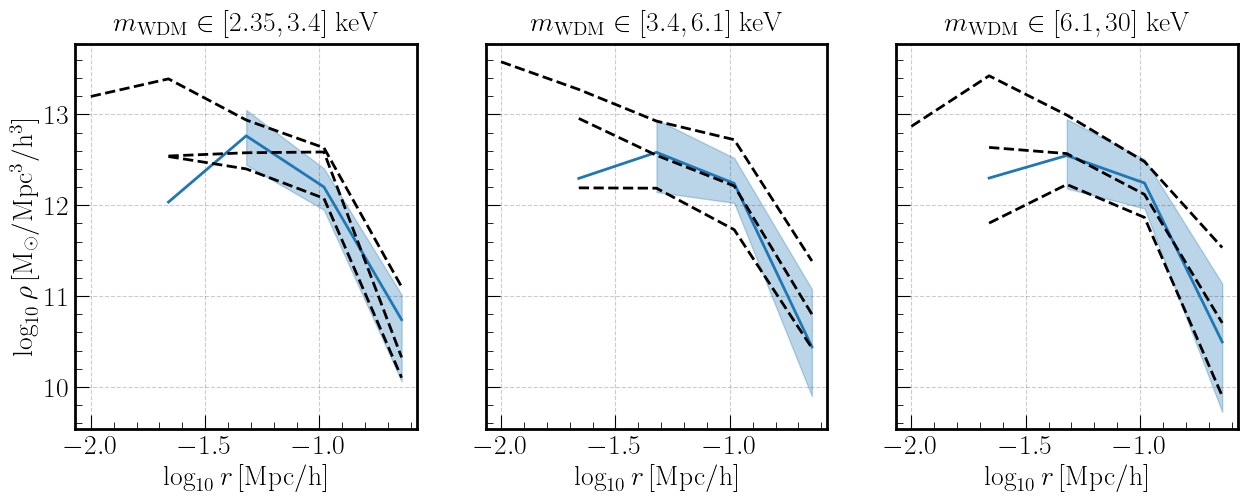

In [86]:
fig, axes = plt.subplots(
    1, num_wdm_bins, figsize=(5 * num_wdm_bins, 5), 
    sharey=True, sharex=True)

for i in range(num_wdm_bins):
    ax = axes[i]
    
    gen_log_rho_q = np.nanpercentile(gen_log_rho[i], q=q, axis=0)
    ax.plot(
        log_r_bins[:-1], gen_log_rho_q[0], color='C0', lw=2,
        label='score-based diff')
    ax.fill_between(
        log_r_bins[:-1], gen_log_rho_q[1], gen_log_rho_q[2],
        color='C0', alpha=0.3)
    
    truth_log_rho_q = np.nanpercentile(truth_log_rho[i], q=q, axis=0)
    ax.plot(
        log_r_bins[:-1], truth_log_rho_q[0], color='k', lw=2,
        ls='--', label='simulation')
    ax.plot(
        log_r_bins[:-1], truth_log_rho_q[1], color='k', lw=2,
        ls='--')
    ax.plot(
        log_r_bins[:-1], truth_log_rho_q[2], color='k', lw=2,
        ls='--')

    ax.set_xlabel(r'$\log_{10} r \, [\rm Mpc / h]$')
    title = r"$m_\mathrm{{WDM}} \in [{}, {}]$ keV".format(
        wdm_mass_bins[i], wdm_mass_bins[i + 1])
    ax.set_title(title, fontsize=20)

axes[0].set_ylabel(r'$\log_{10} \rho \, [\rm M_\odot / \rm Mpc^3 / h^3]$')
plt.show()

### Pair-wise distances

In [87]:
def calc_pair_dist(pos1, pos2):
    diff = (pos1[:, None, :] - pos2[None, :, :])
    dist = np.sqrt((diff**2).sum(axis=-1))
    dist = dist[dist > 0]  # only works if there are no particles at the same position
    return dist

def calc_tpcf(pos, num_random_factor=10, box_size=1):
    # randomly generate the catalogs7
    num_random = int(num_random_factor * len(pos))
    pos_random = np.random.uniform(
        low=-box_size, high=box_size, size=(num_random, pos.shape[-1]))
    DR_dist = calc_pair_dist(pos, pos_random)
    RR_dist = calc_pair_dist(pos_random, pos_random)
    DD_dist = calc_pair_dist(pos, pos)

    # calculate the tpcf
    return DD_dist, RR_dist, DR_dist

In [88]:
truth_pair_dist = []
for i in range(num_wdm_bins):
    temp = []
    for sample in truth_samples_bins[i]:
        truth_pos = sample[:, :3]
        temp.append(calc_pair_dist(truth_pos, truth_pos))
    truth_pair_dist.append(np.stack(temp))

gen_pair_dist = []
for i in range(num_wdm_bins):
    temp = []
    for sample in gen_samples_bins[i]:
        gen_pos = sample[:, :3]
        temp.append(calc_pair_dist(gen_pos, gen_pos))
    gen_pair_dist.append(np.stack(temp))

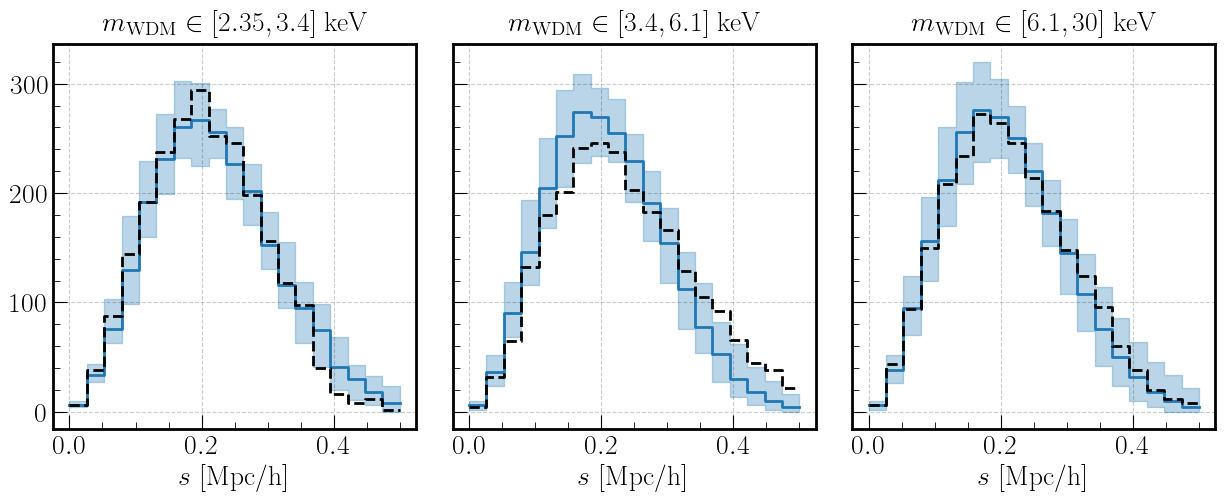

In [89]:
# pair-wise distance bins
bins = np.linspace(0, 0.5, 20)
num_bins = len(bins) - 1
bins_plot = np.zeros(2 * num_bins)
bins_plot[::2] = bins[:-1] 
bins_plot[1::2] = bins[1:]

fig, axes = plt.subplots(
    1, num_wdm_bins, figsize=(5 * num_wdm_bins, 5), sharex=True, sharey=True)

for i in range(num_wdm_bins):
    ax = axes[i]

    counts_q = get_histogram_q(
        gen_pair_dist[i], bins=bins, q=q, cumulative=False)
    ax.plot(
        bins_plot, counts_q[0].repeat(2), color='C0', lw=2, 
        label='score-based diff')
    ax.fill_between(
        bins_plot, counts_q[1].repeat(2), counts_q[2].repeat(2),
        color='C0', alpha=0.3)

    counts_q = get_histogram_q(
        truth_pair_dist[i], bins=bins, q=q, cumulative=False)
    ax.plot(
        bins_plot, counts_q[0].repeat(2), color='k', lw=2, ls='--',
        label='simulation')

# axes[0].set_yscale('log')
# axes[0].set_ylabel(r'N($> \log_{10} M_{\rm subhalo}$)')
for i, ax in enumerate(axes):
    ax.set_xlabel(r'$s$ [Mpc/h]')

    title = r"$m_\mathrm{{WDM}} \in [{}, {}]$ keV".format(
        wdm_mass_bins[i], wdm_mass_bins[i + 1])
    ax.set_title(title, fontsize=20)

# create handles
handles, labels = ax.get_legend_handles_labels()
# fig.legend(
    # handles, labels, loc='upper center', ncol=2, fontsize=20)
fig.subplots_adjust(hspace=0.3, wspace=0.1)
plt.show()

### Pair-wise velocities

In [90]:
truth_pair_vel = []
for i in range(num_wdm_bins):
    temp = []
    for sample in truth_samples_bins[i]:
        truth_vel = sample[:, 3:6]
        temp.append(calc_pair_dist(truth_vel, truth_vel))
    truth_pair_vel.append(np.stack(temp))

gen_pair_vel = []
for i in range(num_wdm_bins):
    temp = []
    for sample in gen_samples_bins[i]:
        gen_vel = sample[:, 3:6]
        temp.append(calc_pair_dist(gen_vel, gen_vel))
    gen_pair_vel.append(np.stack(temp))

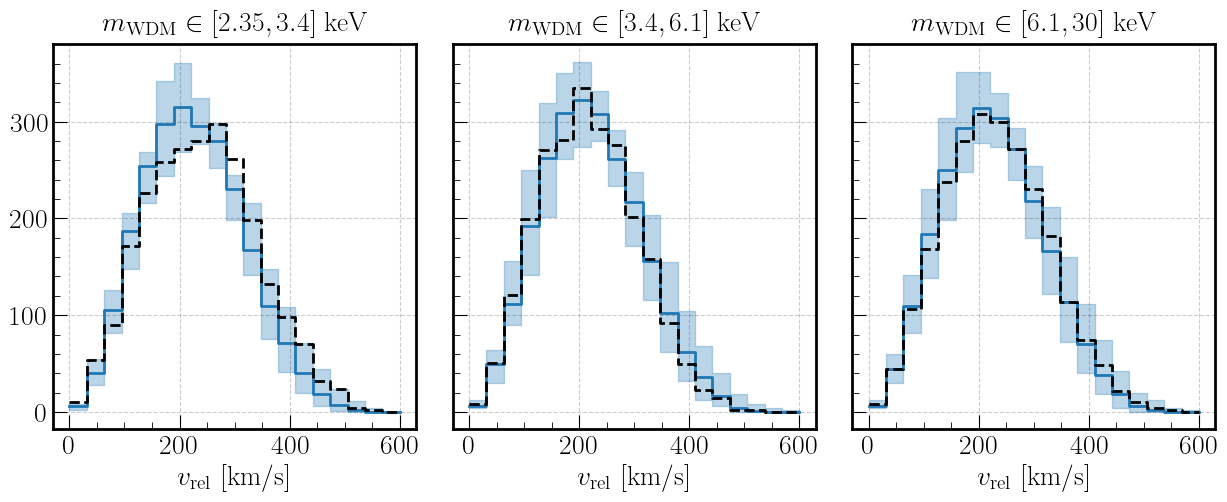

In [91]:
# pair-wise distance bins
bins = np.linspace(0, 600, 20)
num_bins = len(bins) - 1
bins_plot = np.zeros(2 * num_bins)
bins_plot[::2] = bins[:-1] 
bins_plot[1::2] = bins[1:]

fig, axes = plt.subplots(
    1, num_wdm_bins, figsize=(5 * num_wdm_bins, 5), sharex=True, sharey=True)

for i in range(num_wdm_bins):
    ax = axes[i]

    counts_q = get_histogram_q(
        gen_pair_vel[i], bins=bins, q=q, cumulative=False)
    ax.plot(
        bins_plot, counts_q[0].repeat(2), color='C0', lw=2, 
        label='score-based diff')
    ax.fill_between(
        bins_plot, counts_q[1].repeat(2), counts_q[2].repeat(2),
        color='C0', alpha=0.3)

    counts_q = get_histogram_q(
        truth_pair_vel[i], bins=bins, q=q, cumulative=False)
    ax.plot(
        bins_plot, counts_q[0].repeat(2), color='k', lw=2, ls='--',
        label='simulation')

# axes[0].set_yscale('log')
# axes[0].set_ylabel(r'N($> \log_{10} M_{\rm subhalo}$)')
for i, ax in enumerate(axes):
    ax.set_xlabel(r'$v_\mathrm{rel}$ [km/s]')

    title = r"$m_\mathrm{{WDM}} \in [{}, {}]$ keV".format(
        wdm_mass_bins[i], wdm_mass_bins[i + 1])
    ax.set_title(title, fontsize=20)

# create handles
handles, labels = ax.get_legend_handles_labels()
fig.subplots_adjust(hspace=0.3, wspace=0.1)
plt.show()